# CNN With Spectrogram 

## Load Data


In [2]:
import csv
from tqdm import tqdm

label_dict = {}
with open("../ComParE2017_Cold_4students/lab/ComParE2017_Cold.tsv", "r", encoding="utf-8") as f:
    reader = csv.DictReader(f, delimiter="\t")
    rows = list(reader)
    for row in tqdm(rows, desc="Loading labels"):
        label_dict[row["file_name"]] = row["Cold (upper respiratory tract infection)"]


Loading labels: 100%|██████████| 19101/19101 [00:00<00:00, 3821023.55it/s]


In [3]:
import os
def search_in_labels(filename, label_dict):
    base_name = os.path.splitext(filename)[0]
    
    if "_logmel" in base_name:
        base_name = base_name.replace("_logmel", "")
    if "_flipped" in base_name:
        base_name = base_name.replace("_flipped", "")
    
    parts = base_name.split("_")
    if len(parts) >= 2:
        audio_filename = f"{parts[0]}_{parts[1]}.wav"
    else:
        audio_filename = f"{base_name}.wav"
    
    return label_dict.get(audio_filename, None)


In [11]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

class SpectrogramDataset(Dataset):
    def __init__(self, image_paths, label_dict, transform=None, is_training=False):
        self.image_paths = image_paths
        self.label_dict = label_dict
        self.is_training = is_training  
        
        self.base_transform = transforms.Compose([
            transforms.Resize((300, 100)),
            transforms.RandomAffine(degrees=0, translate=(0.3, 0)),

            transforms.ToTensor()
        ])
        
        self.c_train_transform = transforms.Compose([
            transforms.RandomAffine(degrees=0, translate=(0.3, 0)),
            transforms.Resize((300, 100)),
            transforms.ToTensor()
        ])
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        filename = os.path.basename(image_path)
        
        label = search_in_labels(filename, self.label_dict)
        
        image = Image.open(image_path).convert("RGB")

        if self.is_training and label == "C":
            image = self.c_train_transform(image)
        else:
            image = self.base_transform(image)

        label_num = 1 if label == "C" else 0  

        return image, label_num

In [12]:
import random
def create_progressive_undersampling(image_paths, label_dict, stages=[0.4, 0.6, 0.8]):

    all_datasets = []
    
    for stage_ratio in stages:
        cold_paths = []
        healthy_paths = []
        
        for path in image_paths:
            filename = os.path.basename(path)
            label = search_in_labels(filename, label_dict)
            
            if label == "C":
                cold_paths.append(path)
            elif label == "NC":
                healthy_paths.append(path)
        
        target_healthy = int(len(healthy_paths) * stage_ratio)
        sampled_healthy = random.sample(healthy_paths, target_healthy)
        
        stage_paths = cold_paths + sampled_healthy
        random.shuffle(stage_paths)
        
        stage_dataset = SpectrogramDataset(stage_paths, label_dict, is_training=True)
        all_datasets.append(stage_dataset)
        
        print(f"📊 Stage {stage_ratio}: {len(cold_paths)} Cold + {len(sampled_healthy)} Healthy")
    
    return all_datasets

In [13]:
import os
import glob
from torch.utils.data import DataLoader

data_split = ["train_files", "devel_files"]
img_dir = "../spectrogram_images/log_mel"  

def collect_image_paths_devel(split_name):
        sub_dir = os.path.join(img_dir, split_name)
        print(f"🔍 Looking for images in: {sub_dir}")
        
        if not os.path.exists(sub_dir):
            print(f"❌ Directory does not exist: {sub_dir}")
            return []
        
        png_files = glob.glob(os.path.join(sub_dir, "*.png"))
        
        filtered_files = [f for f in png_files if "flipped" not in os.path.basename(f)]
        
        print(f"📁 Found {len(png_files)} PNG files in {split_name}")
        print(f"📋 After filtering out 'flipped' files: {len(filtered_files)} files")
        
        return filtered_files

def collect_image_paths(split_name):
    sub_dir = os.path.join(img_dir, split_name)
    print(f"🔍 Looking for images in: {sub_dir}")
    
    if not os.path.exists(sub_dir):
        print(f"❌ Directory does not exist: {sub_dir}")
        return []
    
    png_files = glob.glob(os.path.join(sub_dir, "*.png"))
    print(f"📁 Found {len(png_files)} PNG files in {split_name}")
    
    return png_files

print("🚀 Collecting image paths...")
train_image_paths = collect_image_paths("train_files")
devel_image_paths = collect_image_paths_devel("devel_files")

progressive_datasets = create_progressive_undersampling(
    train_image_paths, 
    label_dict, 
    stages=[0.3, 0.4, 0.6, 0.8] 
)

selected_stage = 3 
train_dataset = progressive_datasets[selected_stage]
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True)
print(f"✅ Created train loader with {len(train_dataset)} samples")

devel_dataset = SpectrogramDataset(devel_image_paths, label_dict, is_training=False)
test_dataset = SpectrogramDataset(devel_image_paths, label_dict, is_training=False) 
    
devel_loader = DataLoader(devel_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(devel_dataset, batch_size=512, shuffle=False)
print(f"✅ Created devel loader with {len(devel_dataset)} samples")


🚀 Collecting image paths...
🔍 Looking for images in: ../spectrogram_images/log_mel\train_files
📁 Found 10475 PNG files in train_files
🔍 Looking for images in: ../spectrogram_images/log_mel\devel_files
📁 Found 10607 PNG files in devel_files
📋 After filtering out 'flipped' files: 9596 files
📊 Stage 0.3: 1940 Cold + 2560 Healthy
📊 Stage 0.4: 1940 Cold + 3414 Healthy
📊 Stage 0.6: 1940 Cold + 5121 Healthy
📊 Stage 0.8: 1940 Cold + 6828 Healthy
✅ Created train loader with 8768 samples
✅ Created devel loader with 9596 samples


## CNN

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedCNNBinaryClassifier(nn.Module):
    def __init__(self, input_shape=(3, 224, 224), num_classes=1):
        super(ImprovedCNNBinaryClassifier, self).__init__()
        
        self.conv1 = nn.Conv2d(input_shape[0], 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)
        
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2)
        
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))  
        
        self.fc1 = nn.Linear(512 * 4 * 4, 512)  
        self.dropout1 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(0.3)
        
        self.fc3 = nn.Linear(256, num_classes)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)
        
        x = F.relu(self.bn4(self.conv4(x)))
        
        x = self.adaptive_pool(x) 
        
        x = x.view(x.size(0), -1)  # [batch, 512*4*4]
        
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        
        x = self.fc3(x)
        
        return x

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ImprovedFocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean', pos_weight=None):
        super(ImprovedFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.pos_weight = pos_weight
        
    def forward(self, inputs, targets):
        if self.pos_weight is not None:
            bce_loss = F.binary_cross_entropy_with_logits(
                inputs, targets, 
                pos_weight=self.pos_weight,
                reduction='none'
            )
        else:
            bce_loss = F.binary_cross_entropy_with_logits(
                inputs, targets, 
                reduction='none'
            )
        
        probs = torch.sigmoid(inputs)
        
        pt = torch.where(targets == 1, probs, 1 - probs)
        
        if self.alpha is not None:
            if isinstance(self.alpha, (float, int)):
                alpha_t = torch.where(targets == 1, self.alpha, 1 - self.alpha)
            else:
                alpha_t = self.alpha.gather(0, targets.long())
        else:
            alpha_t = 1.0
        
        focal_weight = alpha_t * (1 - pt) ** self.gamma
        
        focal_loss = focal_weight * bce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

def create_focal_loss_for_imbalanced_data(pos_ratio, neg_ratio, gamma=2.0, device='cuda'):
    pos_weight = torch.tensor(neg_ratio / pos_ratio).to(device)
    
    alpha = 0.25 
    
    return ImprovedFocalLoss(
        alpha=alpha,
        gamma=gamma,
        pos_weight=pos_weight,
        reduction='mean'
    )

class AdaptiveFocalLoss(nn.Module):
    def __init__(self, initial_alpha=0.25, initial_gamma=2.0, 
                 alpha_schedule=None, gamma_schedule=None):
        super(AdaptiveFocalLoss, self).__init__()
        self.alpha = initial_alpha
        self.gamma = initial_gamma
        self.alpha_schedule = alpha_schedule
        self.gamma_schedule = gamma_schedule
        self.epoch = 0
        
    def update_epoch(self, epoch):
        self.epoch = epoch
        if self.alpha_schedule:
            self.alpha = self.alpha_schedule(epoch)
        if self.gamma_schedule:
            self.gamma = self.gamma_schedule(epoch)
    
    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        probs = torch.sigmoid(inputs)
        pt = torch.where(targets == 1, probs, 1 - probs)
        
        alpha_t = torch.where(targets == 1, self.alpha, 1 - self.alpha)
        focal_weight = alpha_t * (1 - pt) ** self.gamma
        
        return (focal_weight * bce_loss).mean()

## Training

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ImprovedCNNBinaryClassifier().to(device)
# model = CNNBinaryClassifier(input_channels=3).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(2).to(device))  
# criterion = create_focal_loss_for_imbalanced_data(0.2, 0.8, device=device)
# criterion = AdaptiveFocalLoss(initial_alpha=0.25, initial_gamma=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-8)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',           
    factor=0.5,           
    patience=3,           
    min_lr=1e-12,         
    threshold=0.001,      
    threshold_mode='rel', 
    cooldown=2          
)

num_epochs = 100

threshold = 0.5

TypeError: ImprovedCNNBinaryClassifier.__init__() got an unexpected keyword argument 'input_channels'

In [15]:
print(f"Using device: {device}")


Using device: cuda


### Training Loop

In [24]:
import time
from sklearn.metrics import accuracy_score, f1_score


best_val_loss = float('inf')
best_f1 = 0.0
patience = 5
patience_counter = 0
training_losses = []
validation_losses = []
start_time = time.time()
early_stop_counter  = 0

print("Starting training...\n")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_preds, all_labels = [], []

    print(f'\n{"="*80}')
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'{"="*80}\n')

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} Training")

    for batch_X, batch_y in progress_bar:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        # Forward
        optimizer.zero_grad()
        logits = model(batch_X).squeeze()
        loss = criterion(logits, batch_y.float())

        # Backward
        loss.backward()
        optimizer.step()

        preds = (torch.sigmoid(logits) > threshold).long()
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

        running_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

    epoch_loss = running_loss / len(train_loader)
    training_losses.append(epoch_loss)
    
    train_accuracy = accuracy_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds)


    model.eval()
    val_loss, val_preds, val_labels = 0.0, [], []

    with torch.no_grad():
        for batch_X, batch_y in tqdm(devel_loader, desc="Validating"):
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            logits = model(batch_X).squeeze()
            loss = criterion(logits, batch_y.float())
            val_loss += loss.item()

            preds = (torch.sigmoid(logits) > threshold).long()
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(batch_y.cpu().numpy())

    avg_val_loss = val_loss / len(devel_loader)
    validation_losses.append(avg_val_loss)
    
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_f1 = f1_score(val_labels, val_preds)

    scheduler.step(avg_val_loss)  

    current_lr = optimizer.param_groups[0]['lr']

    print(f"\nEpoch [{epoch+1}] Summary:")
    print(f"  🎯 Learning Rate: {current_lr:.2e}") 

    print(f"  📈 Training   - Loss: {epoch_loss:.4f}, Acc: {train_accuracy:.4f}, F1: {train_f1:.4f}")
    print(f"  📊 Validation - Loss: {avg_val_loss:.4f}, Acc: {val_accuracy:.4f}, F1: {val_f1:.4f}")
    print(f"  📦 Processed  - Train: {len(all_labels)} samples, Val: {len(val_labels)} samples")

    if val_f1 > best_f1:
        best_f1 = val_f1
        early_stop_counter = 0
        torch.save(model.state_dict(), "best_sampler_model_2_newNN.pth")
        print(f"🌟 New best F1: {best_f1:.4f}, saving model...")
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"No improvement in F1 for {patience} epochs, early stopping...")
            break

print(f"\n🎉 Training complete in {(time.time() - start_time)/60:.2f} min")
print(f"Best Validation F1: {best_f1:.4f}")

Starting training...


Epoch [1/100]



Epoch 1 Training:   0%|          | 0/137 [00:03<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x51200 and 7680x512)

✅ Epochs completed: 42 / Defined: 100
📁 Saved loss curve and CSV


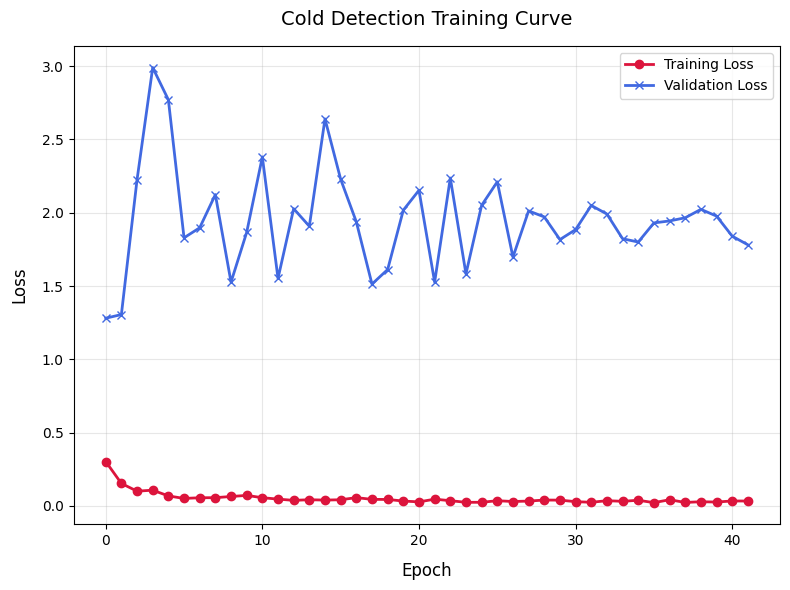

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

plt.figure(figsize=(8, 6))
plt.plot(training_losses, label='Training Loss', color='crimson', marker='o', linewidth=2, markersize=6)
plt.plot(validation_losses, label='Validation Loss', color='royalblue', marker='x', linewidth=2, markersize=6)

plt.title('Cold Detection Training Curve', fontsize=14, pad=15)
plt.xlabel('Epoch', fontsize=12, labelpad=10)
plt.ylabel('Loss', fontsize=12, labelpad=10)
plt.legend(frameon=True, fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

print(f"✅ Epochs completed: {len(training_losses)} / Defined: {num_epochs}")

loss_df = pd.DataFrame({
    "epoch": list(range(1, len(training_losses) + 1)),
    "training_loss": training_losses,
    "validation_loss": validation_losses
})
loss_df.to_csv("cold_training_loss.csv", index=False)
print("📁 Saved loss curve and CSV")

In [19]:
from sklearn.metrics import recall_score
val_preds = []
val_labels = []
val_probs = []
model.eval()
with torch.no_grad():
    for X, y in devel_loader:
        logits = model(X.to(device)).squeeze()
        probs = torch.sigmoid(logits)
        preds = (probs > 0.7).long()
        val_probs.extend(probs.cpu().numpy())
        val_preds.extend(preds.cpu().numpy())
        val_labels.extend(y.numpy())


uar = recall_score(val_labels, val_preds, average='macro')
print(f"Validation UAR: {uar:.4f}")

if len(set(val_labels)) > 1 and len(set(val_preds)) > 1:
    class_recalls = recall_score(val_labels, val_preds, average=None)
    print(f"Class 0 (Healthy) Recall: {class_recalls[0]:.4f}")
    print(f"Class 1 (Cold) Recall: {class_recalls[1]:.4f}")

Validation UAR: 0.5869
Class 0 (Healthy) Recall: 0.9973
Class 1 (Cold) Recall: 0.1766


预测分布: {np.int64(0): 10227, np.int64(1): 380}
真实标签分布: {np.int64(0): 8585, np.int64(1): 2022}


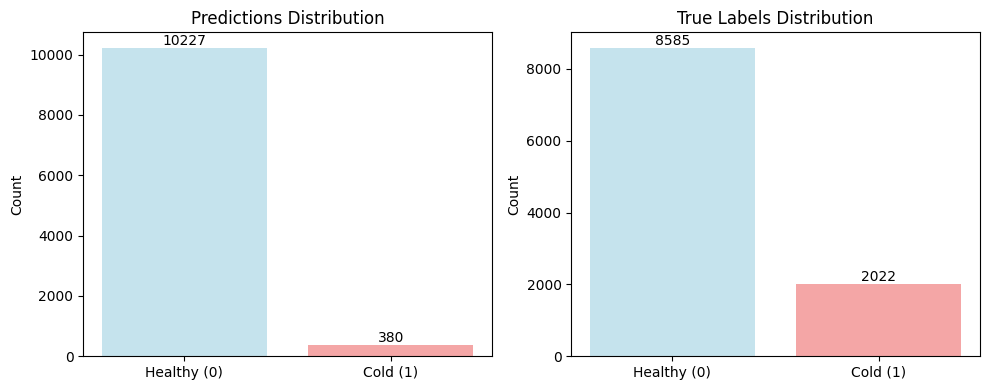


总样本数: 10607
预测为Healthy: 10227 (96.4%)
预测为Cold: 380 (3.6%)
实际Healthy: 8585 (80.9%)
实际Cold: 2022 (19.1%)


In [20]:
import matplotlib.pyplot as plt
from collections import Counter

pred_counts = Counter(val_preds)
label_counts = Counter(val_labels)

print(f"预测分布: {dict(pred_counts)}")
print(f"真实标签分布: {dict(label_counts)}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

categories = ['Healthy (0)', 'Cold (1)']
pred_values = [pred_counts.get(0, 0), pred_counts.get(1, 0)]
ax1.bar(categories, pred_values, color=['lightblue', 'lightcoral'], alpha=0.7)
ax1.set_title('Predictions Distribution')
ax1.set_ylabel('Count')
for i, v in enumerate(pred_values):
    ax1.text(i, v + max(pred_values)*0.01, str(v), ha='center')

label_values = [label_counts.get(0, 0), label_counts.get(1, 0)]
ax2.bar(categories, label_values, color=['lightblue', 'lightcoral'], alpha=0.7)
ax2.set_title('True Labels Distribution')
ax2.set_ylabel('Count')
for i, v in enumerate(label_values):
    ax2.text(i, v + max(label_values)*0.01, str(v), ha='center')

plt.tight_layout()
plt.show()

total = len(val_preds)
print(f"\n总样本数: {total}")
print(f"预测为Healthy: {pred_counts.get(0, 0)} ({pred_counts.get(0, 0)/total:.1%})")
print(f"预测为Cold: {pred_counts.get(1, 0)} ({pred_counts.get(1, 0)/total:.1%})")
print(f"实际Healthy: {label_counts.get(0, 0)} ({label_counts.get(0, 0)/total:.1%})")  
print(f"实际Cold: {label_counts.get(1, 0)} ({label_counts.get(1, 0)/total:.1%})")

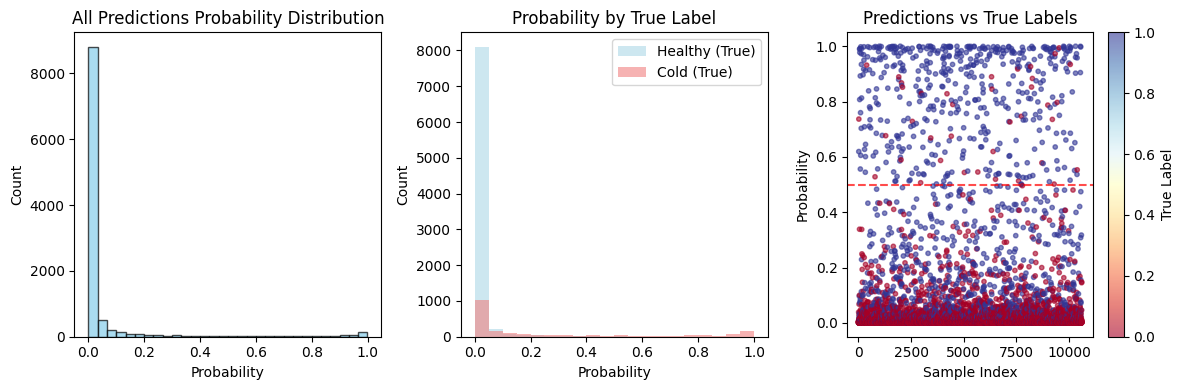

概率分布统计:
平均概率: 0.0610
概率标准差: 0.1852
最小概率: 0.0000
最大概率: 1.0000

Healthy样本平均概率: 0.0157
Cold样本平均概率: 0.2533


In [21]:
import matplotlib.pyplot as plt
import numpy as np

val_probs = np.array(val_probs)
val_labels = np.array(val_labels)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(val_probs, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('All Predictions Probability Distribution')
plt.xlabel('Probability')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
healthy_probs = val_probs[val_labels == 0]
cold_probs = val_probs[val_labels == 1]

plt.hist(healthy_probs, bins=20, alpha=0.6, label='Healthy (True)', color='lightblue')
plt.hist(cold_probs, bins=20, alpha=0.6, label='Cold (True)', color='lightcoral')
plt.title('Probability by True Label')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.legend()

plt.subplot(1, 3, 3)
plt.scatter(range(len(val_probs)), val_probs, c=val_labels, 
           cmap='RdYlBu', alpha=0.6, s=10)
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.7)
plt.title('Predictions vs True Labels')
plt.xlabel('Sample Index')
plt.ylabel('Probability')
plt.colorbar(label='True Label')

plt.tight_layout()
plt.show()


print("=" * 40)
print("概率分布统计:")
print("=" * 40)
print(f"平均概率: {val_probs.mean():.4f}")
print(f"概率标准差: {val_probs.std():.4f}")
print(f"最小概率: {val_probs.min():.4f}")
print(f"最大概率: {val_probs.max():.4f}")

print(f"\nHealthy样本平均概率: {healthy_probs.mean():.4f}")
print(f"Cold样本平均概率: {cold_probs.mean():.4f}")

In [22]:
import numpy as np
from sklearn.metrics import f1_score, recall_score

probs = []   
labels = []

model.eval()
with torch.no_grad():
    for X, y in devel_loader:
        logits = model(X.to(device)).squeeze()
        p = torch.sigmoid(logits).cpu().numpy()
        probs.extend(p)
        labels.extend(y.numpy())

probs = np.array(probs)
labels = np.array(labels)

best_t, best_uar = 0.5, 0
best_f1 = 0

print("🎯 Threshold optimization using UAR:")
print("-" * 50)

for t in np.linspace(0.1, 0.9, 81):
    preds = (probs > t).astype(int)
    
    uar = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds)
    
    if uar > best_uar:
        best_uar = uar
        best_t = t
        best_f1 = f1

print(f"🏆 Best Threshold = {best_t:.2f}")
print(f"📊 UAR = {best_uar:.3f}")


🎯 Threshold optimization using UAR:
--------------------------------------------------
🏆 Best Threshold = 0.10
📊 UAR = 0.698


## Test 

In [23]:
model.eval()

test_preds = []
test_labels = []

threshold = best_t

with torch.no_grad():
    with tqdm(total=len(test_loader.dataset),
              desc="Testing",
              unit="samples",
              ncols=100) as progress_bar:
        for batch_X, batch_y in test_loader:
            batch_X = batch_X.to(device)
            batch_y = batch_y.to(device)

            logits = model(batch_X).squeeze() 
            probs = torch.sigmoid(logits)
            preds = (probs > threshold).long()

            test_preds.extend(preds.cpu().tolist())
            test_labels.extend(batch_y.cpu().tolist())

            progress_bar.update(batch_X.size(0))



Testing: 100%|██████████████████████████████████████████| 10607/10607 [01:00<00:00, 174.42samples/s]


In [24]:
from sklearn.metrics import classification_report, confusion_matrix, recall_score
import numpy as np

uar = recall_score(test_labels, test_preds, average='macro')

print(f"\n📈 PERFORMANCE METRICS:")
print(f"   F1 Score: {f1:.4f}")
print(f"   UAR (Unweighted Average Recall): {uar:.4f}")

if len(set(test_labels)) > 1 and len(set(test_preds)) > 1:
    cm = confusion_matrix(test_labels, test_preds)
    
    class_recalls = []
    for i in range(len(cm)):
        if cm[i].sum() > 0:  
            recall = cm[i, i] / cm[i].sum()
            class_recalls.append(recall)
        else:
            class_recalls.append(0.0)
    
    print(f"\n🎯 PER-CLASS RECALL:")
    class_names = ['Healthy', 'Cold']
    for i, (name, recall) in enumerate(zip(class_names, class_recalls)):
        print(f"   Class {i} ({name}): {recall:.4f}")
    
    manual_uar = np.mean(class_recalls)
    print(f"\n✅ UAR Verification:")
    print(f"   sklearn UAR: {uar:.4f}")
    print(f"   Manual UAR:  {manual_uar:.4f}")
    print(f"   Match: {'✓' if abs(uar - manual_uar) < 0.0001 else '✗'}")


📈 PERFORMANCE METRICS:
   F1 Score: 0.2029
   UAR (Unweighted Average Recall): 0.6973

🎯 PER-CLASS RECALL:
   Class 0 (Healthy): 0.9698
   Class 1 (Cold): 0.4248

✅ UAR Verification:
   sklearn UAR: 0.6973
   Manual UAR:  0.6973
   Match: ✓
